<a href="https://colab.research.google.com/github/Sr123Saha/3_intensiv_3/blob/main/Untitled12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, r2_score

# Загрузка данных
train_df = pd.read_excel("train.xlsx")
test_df = pd.read_excel("test.xlsx")

# Создание новых признаков
train_df["year"] = train_df["dt"].dt.year
train_df["month"] = train_df["dt"].dt.month
train_df["week"] = train_df["dt"].dt.isocalendar().week
train_df["dayofyear"] = train_df["dt"].dt.dayofyear
train_df["quarter"] = train_df["dt"].dt.quarter

# Добавление лагов
for lag in range(1, 6):
    train_df[f"lag_{lag}"] = train_df["Цена на арматуру"].shift(lag)

# Скользящее среднее
train_df["rolling_mean_3"] = train_df["Цена на арматуру"].rolling(window=3).mean()
train_df["rolling_mean_6"] = train_df["Цена на арматуру"].rolling(window=6).mean()

# Производные признаки
train_df["diff_1"] = train_df["Цена на арматуру"].diff(1)
train_df["diff_2"] = train_df["Цена на арматуру"].diff(2)
train_df["log_price"] = np.log1p(train_df["Цена на арматуру"])

# Удаляем строки с NaN после лагов
train_df = train_df.dropna()

# Разделение данных
X = train_df.drop(columns=["dt", "Цена на арматуру"])
y = train_df["Цена на арматуру"]

# Используем TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Подбор гиперпараметров
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)

# Лучшая модель
best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

# Оценка модели
y_pred = best_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")


Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MAE: 56.91910625239742
R2 Score: 0.9999336121272531


In [ ]:
# Предсказание на тестовом наборе
test_df["year"] = test_df["dt"].dt.year
test_df["month"] = test_df["dt"].dt.month
test_df["week"] = test_df["dt"].dt.isocalendar().week
test_df["dayofyear"] = test_df["dt"].dt.dayofyear
test_df["quarter"] = test_df["dt"].dt.quarter
for lag in range(1, 6):
    test_df[f"lag_{lag}"] = train_df["Цена на арматуру"].shift(lag).iloc[-len(test_df):].values

test_df["rolling_mean_3"] = train_df["Цена на арматуру"].rolling(window=3).mean().iloc[-len(test_df):].values
test_df["rolling_mean_6"] = train_df["Цена на арматуру"].rolling(window=6).mean().iloc[-len(test_df):].values
test_df["diff_1"] = train_df["Цена на арматуру"].diff(1).iloc[-len(test_df):].values
test_df["diff_2"] = train_df["Цена на арматуру"].diff(2).iloc[-len(test_df):].values
test_df["log_price"] = np.log1p(train_df["Цена на арматуру"]).iloc[-len(test_df):].values

# Удаляем NaN
test_df = test_df.dropna()
X_test = test_df.drop(columns=["dt", "Цена на арматуру"])
test_df["Прогноз"] = best_model.predict(X_test)



In [ ]:
# Оценка модели на тестовых данных
test_mae = mean_absolute_error(test_df["Цена на арматуру"], test_df["Прогноз"])
test_r2 = r2_score(test_df["Цена на арматуру"], test_df["Прогноз"])
print(f"Test MAE: {test_mae}")
print(f"Test R2 Score: {test_r2}")

Test MAE: 12681.0
Test R2 Score: -20.258926703073193


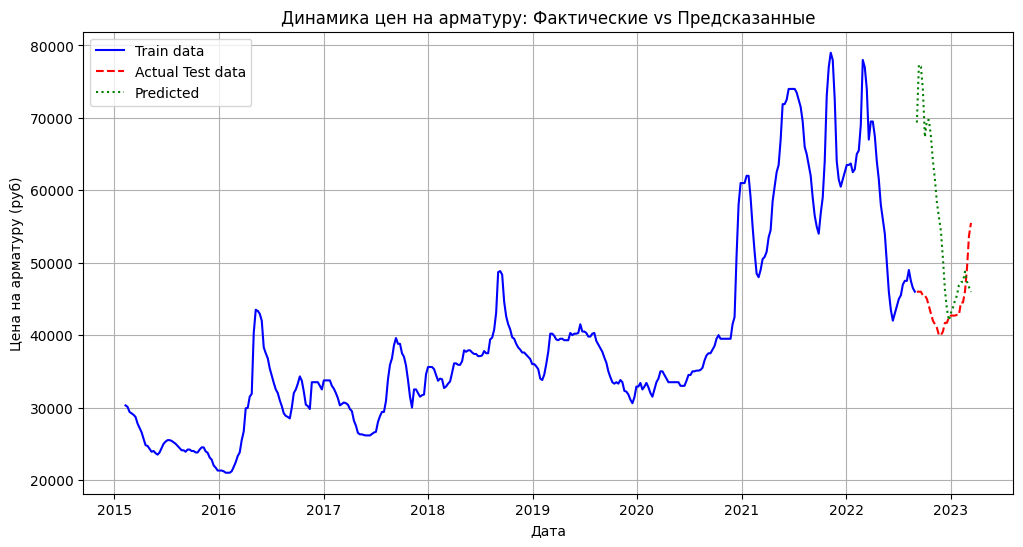

In [ ]:
# График предсказаний
plt.figure(figsize=(12, 6))
plt.plot(train_df["dt"], train_df["Цена на арматуру"], label="Train data", color='blue')
plt.plot(test_df["dt"], test_df["Цена на арматуру"], label="Actual Test data", color='red', linestyle='dashed')
plt.plot(test_df["dt"], test_df["Прогноз"], label="Predicted", color='green', linestyle='dotted')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру (руб)")
plt.title("Динамика цен на арматуру: Фактические vs Предсказанные")
plt.legend()
plt.grid()
plt.show()

тут вот темочка зеленая повторяет синюю вроде норм, а вроде и не прикольно

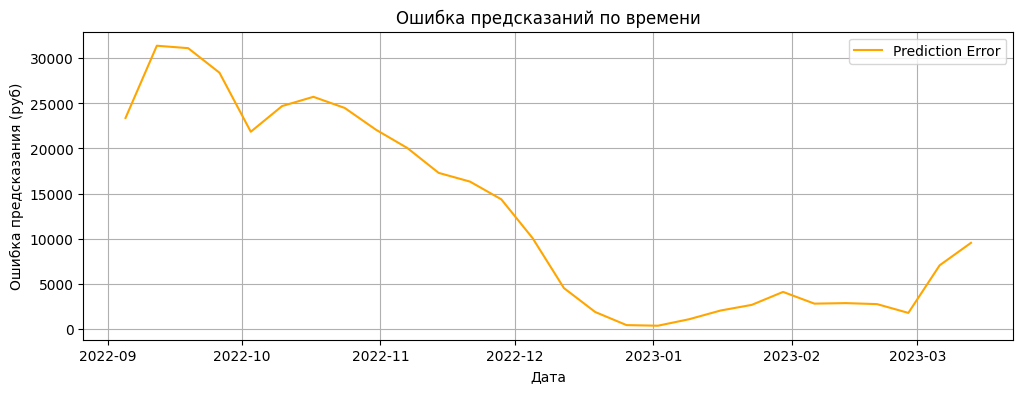

In [ ]:
# График ошибок
plt.figure(figsize=(12, 4))
plt.plot(test_df["dt"], abs(test_df["Цена на арматуру"] - test_df["Прогноз"]), label="Prediction Error", color='orange')
plt.xlabel("Дата")
plt.ylabel("Ошибка предсказания (руб)")
plt.title("Ошибка предсказаний по времени")
plt.legend()
plt.grid()
plt.show()
